# İsim: Muhammet Fatih
# Soyisim: ANAÇ
# Numara: 121521057

## Verisetinin Yüklenmesi

In [13]:
import numpy as np
import pandas as pd

jhns= pd.read_csv("C:/Users/m.fatih/OneDrive/Masaüstü/Ilk Ders Ist Yazilimlar 2/MakeupAlley_Reviews.csv")
jhns.head()


,date,rating,review,product
0,2021-07,1.0,I normally only need to wash my hair every 3-4...,Orchid Oil Shampoo
1,2020-08,2.0,"My hair is long, thick, and dries mostly strai...",Orchid Oil Shampoo
2,2019-08,4.0,-lathers easily \n-nice smell\n-good for oily ...,Orchid Oil Shampoo
3,2018-08,5.0,I rarely have good results with using drug sto...,Orchid Oil Shampoo
4,2018-08,1.0,Has a light orchid scent. This shampoo left my...,Orchid Oil Shampoo


### "Date" değişkeni yorumun yapıldığı tarihi, "rating" değişkeni kullanıcının aldığı ürüne 5 üzerinden verdiği puanı, "review" değişkeni kullanıcının aldığı ürüne yaptığı yorumu, "product" değişkeni kullanıcının aldığı ürünün ismini gösteriyor.
### Daha sonra lojistik regresyon uygulaması yapacağım için ve bağımlı değişkenlerimin yetersiz olduğunu düşündüğüm için verisetime cinsiyet değişkeni ve yaş değişkeni ekledim. Cinsiyet değişkeninin değerleri rastgele olarak male ve female oldu. Yaş değişkeninin değerleri de 15 ile 60 arasından rastgele değerler oldu.

In [3]:
def rastgele_cinsiyet_ekleme(veriseti):
    satir_sayisi=len(veriseti)
    cinsiyetler = np.random.choice(['male', 'female'], size=satir_sayisi)
    veriseti["gender"]=cinsiyetler

rastgele_cinsiyet_ekleme(jhns)

jhns["age"]= np.random.randint(15,61,size=len(jhns))


## Eksik Gözlem Kontrolü

In [4]:
jhns.isnull().any().sum()

df_jhns = pd.DataFrame(jhns)
df_jhns.isnull().any().sum()
df_jhns = df_jhns.dropna()
print(df_jhns.isnull().any().sum())

jhns= df_jhns

0


### Eksik gözlem yok
## Yorumların Tamamının Küçük Harfli Hale Getirilmesi

In [5]:
jhns2=jhns.copy()
jhns3= jhns2["review"].apply(lambda x: x.lower())

## Yorumlardaki Noktalama İşaretlerinin Silinmesi

In [6]:
jhns3= jhns3.str.replace("[^\w\s]", "", regex=True)
jhns3

0       i normally only need to wash my hair every 34 ...
1       my hair is long thick and dries mostly straigh...
2         lathers easily \nnice smell\ngood for oily hair
3       i rarely have good results with using drug sto...
4       has a light orchid scent this shampoo left my ...
                              ...                        
2189    generally the appeal of organic conditioners i...
2190    i liked the coconut series so i decided to giv...
2191    i bought this conditioner while staying with f...
2192    i bought this conditioner bc it had a mailin f...
2193    this is the first product i bought after i wen...
Name: review, Length: 2194, dtype: object

## Yorumlardaki Sayıların Silinmesi

In [7]:
jhns3=jhns3.apply(lambda i: " ".join(i for i in i.split() if not i.isnumeric()))

## Yorumlardaki Stopwords İfadelerinin Silinmesi

In [8]:
import nltk
from nltk.corpus import stopwords
stp= stopwords.words("english")

jhns3= jhns3.apply(lambda x: " ".join(x for x in x.split() if x not in stp))

## Lemmatization Adımı

In [11]:
import textblob
from textblob import Word
from textblob import TextBlob
nltk.download("omw-1.4")
nltk.download("wordnet")

jhns3= jhns3.apply(lambda x: " ".join(Word(i).lemmatize() for i in x.split()))
jhns3
jhns2["review"]=jhns3

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\m.fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\m.fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Terim Frekansları Hesaplatma

In [66]:
frekanslar = jhns3.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
frekanslar.columns=["Kelime","Sayi"]
print(frekanslar)

          Kelime    Sayi
0           hair  7249.0
1            day   529.0
2        shampoo  2143.0
3            use  1244.0
4       normally    51.0
...          ...     ...
8222      raleys     1.0
8223        pale     1.0
8224  seethrough     1.0
8225        twig     1.0
8226    itbefore     1.0

[8227 rows x 2 columns]


### Yorumlarda en çok geçen kelimenin "hair" kelimesi olduğu görülüyor. Daha sonra "shampoo" ve "use" kelimeleri geliyor. Yorumların, şampuan alan kişilerin aldıkları şampuanları kullandıktan sonra o şampuanla ilgili yaptıkları değerlendirmelerden oluştuğu anlaşılıyor. Bu durumu Wordcloud ile görsel yardımıyla inceleyebiliriz.

## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

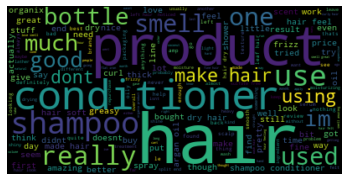

In [67]:
metin=""
for i in jhns3:
    metin=metin+i+" "

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as mtl

wrdcl= WordCloud().generate(metin)
mtl.imshow(wrdcl, interpolation="bilinear")
mtl.axis("off")

### Wordcloud yardımıyla da "hair", "shampoo", "use" kelimeleri büyük yazıldığı için, bu kelimelerin yapılan yorumlarda çok geçtiği anlaşılıyor.

## Duygu Analizi

In [68]:
duygular=[]

for yorum in jhns3:
    blob=TextBlob(yorum)
    duygu=blob.sentiment.polarity
    
    if duygu>0:
        sent=1
    elif duygu<0:
        sent=-1
    else:
        sent=0
    duygular.append(sent)

    
    
pozitif_sayi = duygular.count(1)
negatif_sayi = duygular.count(-1)
nötr_sayi = duygular.count(0)    

    
tablo = pd.DataFrame([[pozitif_sayi, negatif_sayi, nötr_sayi]], columns=["Pozitif", "Negatif", "Nötr"], index=["Toplam"])

print("\n","\n",tablo,"\n")

jhns2["sentiment"] = duygular
jhns2.head()


 
         Pozitif  Negatif  Nötr
Toplam     1857      321    16 



,date,rating,review,product,gender,age,sentiment
0,2021-07,1.0,normally need wash hair every day shampoo hair...,Orchid Oil Shampoo,male,54,-1
1,2020-08,2.0,hair long thick dry mostly straight wave balay...,Orchid Oil Shampoo,male,20,1
2,2019-08,4.0,lather easily nice smell good oily hair,Orchid Oil Shampoo,female,15,1
3,2018-08,5.0,rarely good result using drug store shampoo co...,Orchid Oil Shampoo,female,49,1
4,2018-08,1.0,light orchid scent shampoo left fine dry hair ...,Orchid Oil Shampoo,female,53,1


### En üstte gözüken dataframe çıktısına bakıldığında, pozitif yorumların 1857, negatif yorumların 321, nötr yorumların 16 tane olduğu görülüyor. Alınan ürünlerin çoğundan memnun kalındığı anlaşılıyor.
### Yapılan her yorum; pozitif kelimeler içeriyorsa 1'e yakın, negatif kelimeler içeriyorsa -1'e yakın ve nötr kelimeler içeriyorsa 0 değerlerini alıyor. Daha kolay yorumlayabilmek için 0'dan büyük değerleri 1, 0'dan küçük değerleri ise -1 olarak atayıp duygu listesine ekledim. Bu sayede negatif ve pozitif yorumlar daha net bir şekilde ayrıldı. Nötr yorum 16 tane olduğu için o yorumların olduğu satırları verimden çıkartıyorum. Bu şekilde sentiment değişkeni -1 ve 1 değerlerini alıyor ve Lojistik Regresyon modeline uygun bir formata dönüşüyor.

In [69]:
jhns2 =jhns2[jhns2['sentiment'] != 0]
jhns2["sentiment"]=jhns2["sentiment"].replace(-1,0)
jhns2["sentiment"].value_counts()

1    1857
0     321
Name: sentiment, dtype: int64

### Nötr yorumları veriden çıkarttım. Geriye 1857 pozitif yorum, 321 negatif yorum kaldı. Lojistik regresyon formatına daha çok uyması için negatif yorumların -1 değerini 0 olarak değiştirdim. "sentiment" değişkeni, negatif yorumları temsil eden 0 değerlerinden ve pozitif yorumları temsil eden 1 değerlerinden oluşuyor.

## Bar Grafiği

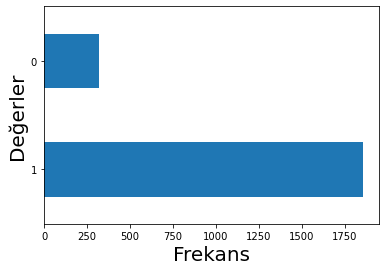

In [70]:
import matplotlib.pyplot as plt
jhns2["sentiment"].value_counts().plot.barh()
plt.xlabel("Frekans", fontsize=20)
plt.ylabel("Değerler", fontsize=20)
plt.show()

In [71]:
jhns2["product"].value_counts()

Nourishing Coconut Milk Shampoo                    60
Coconut Milk Anti-Breakage Serum                   60
Renewing Argan Oil Morocco Penetrating Oil         60
Rejuvenating Cherry Blossom Ginseng Shampoo        60
Ever Straight Brazilian Keratin Therapy            60
                                                   ..
Healing + Vitamin E Conditioner                     1
Rejuvenating Cherry Blossom Ginseng Shine Spray     1
Healing + Vitamin E Shampoo                         1
Frizz Defy + Coconut Miracle Oil Air Dry Cream      1
Coconut Curls Finishing Spray                       1
Name: product, Length: 166, dtype: int64

### Yukarıdaki satırda da görüldüğü gibi belirli ürünler çok az sayıda alınmış. En çok alınan ürünlerin sayısı 60 olduğu için ve birçok ürün 60 defa alındığı için 60'tan az alınan ürünlerin olduğu satırları verisetimden çıkartıyorum.

In [72]:
tekrar_sayisi=jhns2["product"].value_counts()
az_tekrar_edilenler_indeks= tekrar_sayisi[tekrar_sayisi < 60].index
jhns2 =jhns2[jhns2['product'].apply(lambda x: x not in az_tekrar_edilenler_indeks)]
jhns2
jhns2["product"].value_counts()

Renewing Argan Oil Morocco Penetrating Oil                             60
Moroccan Argan Oil Renewing Treatment [DISCONTINUED (reformulated)]    60
Nourishing Coconut Milk Shampoo                                        60
Rejuvenating Cherry Blossom Ginseng Shampoo                            60
Thick & Full Biotin & Collagen Shampoo                                 60
Coconut Milk Anti-Breakage Serum                                       60
Ever Straight Brazilian Keratin Therapy                                60
Renewing Argan Oil Morocco Shampoo                                     60
Name: product, dtype: int64

## Dummy Değişken Atama, Bağımlı ve Bağımsız Değişkenlerin Belirlenmesi

In [73]:
jhns2 = pd.get_dummies(jhns2, columns=['product', 'gender'])
print(jhns2.columns)

Index(['date', 'rating', 'review', 'age', 'sentiment',
       'product_Coconut Milk Anti-Breakage Serum',
       'product_Ever Straight Brazilian Keratin Therapy',
       'product_Moroccan Argan Oil Renewing Treatment [DISCONTINUED (reformulated)]',
       'product_Nourishing Coconut Milk Shampoo',
       'product_Rejuvenating Cherry Blossom Ginseng Shampoo',
       'product_Renewing Argan Oil Morocco Penetrating Oil',
       'product_Renewing Argan Oil Morocco Shampoo',
       'product_Thick & Full Biotin & Collagen Shampoo', 'gender_female',
       'gender_male'],
      dtype='object')


In [74]:
y = jhns2["sentiment"]
x = jhns2.drop(["sentiment","review","date"], axis=1)

### Verisetinden veri çıkarttığım için satır numaraları 0'dan değil 8'den başlıyor. Bunu düzeltmek için:

In [75]:
jhns2.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
x.reset_index(drop=True, inplace=True)
print(y.head())

0    1
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int64


## Sklearn Lojistic Regresyon

In [76]:

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression( solver="liblinear").fit(x,y)


katsayılar=[]
for i in log_model.coef_:
    for j in i:
        katsayılar.append(j)
        
        
degiskenler=[]

for i in x.columns:
    degiskenler.append(i)
    
for i in log_model.intercept_:
    katsayılar.append(i)

degiskenler.append(y.name)

df = pd.DataFrame(list(zip(degiskenler, katsayılar)), columns=["Değişkenler", "Katsayılar"])

print(df)


                                          Değişkenler  Katsayılar
0                                              rating    0.685880
1                                                 age    0.012117
2            product_Coconut Milk Anti-Breakage Serum   -0.428452
3     product_Ever Straight Brazilian Keratin Therapy   -0.162670
4   product_Moroccan Argan Oil Renewing Treatment ...   -0.275278
5             product_Nourishing Coconut Milk Shampoo   -0.009760
6   product_Rejuvenating Cherry Blossom Ginseng Sh...    0.417717
7   product_Renewing Argan Oil Morocco Penetrating...    0.015518
8          product_Renewing Argan Oil Morocco Shampoo    0.071516
9      product_Thick & Full Biotin & Collagen Shampoo   -0.110720
10                                      gender_female   -0.222506
11                                        gender_male   -0.259623
12                                          sentiment   -0.482129


### Katsayılar incelendiğinde, rating değişkenindeki her 1 birimlik artış olumlu yorum yapma ihtimalini 0.68 arttırıyor. Yani bir kişinin aldığı ürünü 5 üzerinden değerlendirmesindeki her 1 birimlik artış, o kişinin pozitif yorum yapma ihtimalini 0.68 arttırır.
### Age değişkenindeki 1 birimlik artış olumlu yorum yapma ihtimalini 0.012 arttırıyor. Bu durum pozitif veya negatif yorum yapmanın yaşla pek ilgili olmadığını gösteriyor. Yaşı daha büyük kişilerin az da olsa pozitif yorum yapma eğiliminde olduğunu gösteriyor.
### Diğer katsayılar da benzer şekilde yorumlanabilir.
### Ürünlerin katsayılarına bakıldığında ise, 'product_Rejuvenating Cherry Blossom Ginseng Shampoo' ürününü alanların pozitif yorum yapma eğiliminde olduğu görülüyor.

## Confusion Matrix ve Accuracy

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix
fits = log_model.predict(x)

print(confusion_matrix(y, fits))
print(accuracy_score(y, fits))

[[  3  77]
 [  3 397]]
0.8333333333333334


### Confusion matrix incelendiğinde, model pozitif yorumları çok iyi bir şekilde tahmin edebiliyorken negatif yorumları çok kötü tahmin ediyor. Model 80 negatif yorumun sadece 3 tanesini negatif olarak tahmin etmiş, 400 pozitif yorumun ise 397'sini pozitif olarak tahmin etmiştir.
### Model %83 doğruluk oranına sahiptir. Modelin tahminlerinin %83'ünün doğru olduğu görülüyor.

## AUC Değeri ve Grafiği

Text(0, 0.5, 'True Positive Rate')

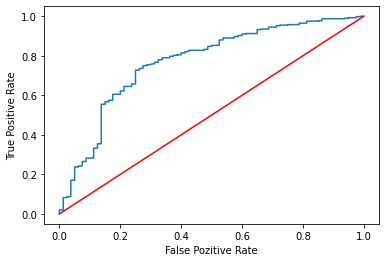

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as mt

aucs= roc_auc_score(y, fits)
fpr, tpr, treshold_val = roc_curve(y, log_model.predict_log_proba(x)[:,1])
mt.figure()
mt.plot(fpr,tpr)
mt.plot([0,1],[0,1],"r") 
mt.xlabel("False Pozitive Rate")
mt.ylabel("True Positive Rate")

In [79]:
jhns2["sentiment"].value_counts()

1    400
0     80
Name: sentiment, dtype: int64

### Verisetinde 400 tane olumlu 80 tane olumsuz yorum içeren gözlem olduğu için eğitim ve test verisini ayırırken train_test_split ile ayırırsam dengesiz dağılabileceği için eşit oranlarda pozitif ve negatif yorum içerecek şekilde verisetimi kendim ayırdım. %30 test %70 eğitim olacak şekilde ayırdım.

In [80]:
from sklearn.model_selection import train_test_split,cross_val_score
import random

random.seed(123)


olumlu_veriseti_index=list(jhns2[jhns2["sentiment"]==1].index)
olumsuz_veriseti_index=list(jhns2[jhns2["sentiment"]==0].index)

test_olumsuz_index=random.sample(olumsuz_veriseti_index, int(len(olumsuz_veriseti_index)*0.3))
test_olumlu_index=random.sample(olumlu_veriseti_index, int(len(olumlu_veriseti_index)*0.3))
test_index=test_olumsuz_index+test_olumlu_index

egitim_olumsuz_index=random.sample(olumsuz_veriseti_index, int(len(olumsuz_veriseti_index)*0.7))
egitim_olumlu_index=random.sample(olumlu_veriseti_index, int(len(olumlu_veriseti_index)*0.7))
egitim_index=egitim_olumsuz_index+egitim_olumlu_index

x_test= x.iloc[test_index]
x_train=x.iloc[egitim_index]

y_test=y.iloc[test_index]
y_train=y.iloc[egitim_index]

In [81]:
log_model= LogisticRegression(solver="liblinear").fit(x_train, y_train)
preds= log_model.predict(x_test)
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test,preds))

0.8472222222222222
[[  3  21]
 [  1 119]]


### Model pozitif değerleri iyi tahmin ediyor negatifleri kötü tahmin ediyor. Accuracy score'da ise çok bir değişiklik yok.

In [82]:
cross_val_score(log_model, x_test, y_test, cv=10).mean()

0.8404761904761904

### Cross validation sonucunda da benzer değer elde edildi.

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_model= RandomForestClassifier().fit(x_train, y_train)
preds_rf= rf_model.predict(x_test)
print(confusion_matrix(y_test, preds_rf))
print(accuracy_score(y_test, preds_rf))

[[ 17   7]
 [  3 117]]
0.9305555555555556


### Counfusion matris ve accuracy skoru incelendiğinde modelin tahmin performansında genel bir artış olduğu görülüyor. OLS Regresyon modeli 1 sınıfını zaten iyi tahmin edebiliyordu ama 0 sınıfındaki tahmin performansı önemli derecede artmış. Model artık hem pozitif'i pozitif olarak hem de negatif'i negatif olarak tahmin edebiliyor.
### Accuracy score'u da 0.93'e yükselmiş.

## Model Optimizasyonu

In [85]:
rf=RandomForestClassifier()
rf_params={"max_depth":[None,100,120,160,200,240], "n_estimators":[100,110,120,130], "min_samples_split": [2,3,4,5,6]}

rf_cv= GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(x_train,y_train)

rf_cv.best_params_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


{'max_depth': 160, 'min_samples_split': 6, 'n_estimators': 110}

In [91]:
rf_best= RandomForestClassifier(max_depth=160 , n_estimators=110 , min_samples_split=6).fit(x_train,y_train)

preds_rf_best= rf_best.predict(x_test)
print(confusion_matrix(y_test, preds_rf_best))
print(accuracy_score(y_test, preds_rf_best))

[[ 13  11]
 [  4 116]]
0.8958333333333334


In [96]:
print(" OLS Regresyon:",accuracy_score(y_test, preds), "\n","Random Forest: ",accuracy_score(y_test, preds_rf))

 OLS Regresyon: 0.8472222222222222 
 Random Forest:  0.9305555555555556


### Model optimizasyonu sonucunda elde edilen parametreler kullanılarak kurulan modelin test seti performansında düşüş oldu. Confusion matrix incelendiğinde modelin pozitif olanları pozitif olarak tahmin edebildiği ama negatif olanları negatif olarak iyi oranda tahmin edemediği görülüyor. Modelin test seti performansındaki düşüşün buradan kaynaklandığı görülüyor.
### OLS Regresyon modelin performansı ve Random Forest modelin performansı kıyaslandığında ise Random Forest modelin performansının çok daha iyi olduğu görülüyor. Optimum model olarak, default parametrelerle kurulan Random Forest modeli seçilmelidir.